The goal of this notebook was to use the SSA name database to help name our child. We wanted a name that invoked nature in some way, and ideally was also common enough to be recognized as a name but not extremely popular, and if possible, unisex.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from datetime import datetime
from nltk.corpus import wordnet

Name data are downloaded from https://www.ssa.gov/oact/babynames/limits.html, and are stored in ./data/ with the format 'yobYYYY.txt', where YYYY is the 4-digit year.
Columns are 'year', 'name', 'sex', 'number'.

In [2]:
allnamesdf = pd.DataFrame()

for f in [f for f in os.listdir('./data/') if f[:3]=='yob']:
    tmpdf = pd.read_csv(os.path.join('./data',f),names=['name','sex','number'])
    tmpdf['year'] = f[3:7]
    allnamesdf = pd.concat([allnamesdf,tmpdf])

The plan of work will be to
1. Reduce the list of names to a set that is (qualitatively) recognizable and not too popular
1. Use wordnet to link potential names to nature-y senses
1. If there are still many names left, determine which ones are unisex

To begin, let's familiarize ourselves with the data before we start adding things. This dataframe has four columns:
- year -- this is not a field from the SSA files directly, it was gathered from the naming of each separate file
- name -- note that unique spellings of the same name are counted separately
- sex assigned to the child at birth
- number of times that the name appears for a given sex in a given year

In [3]:
allnamesdf.head()

,name,sex,number,year
0,Emily,F,25957,2000
1,Hannah,F,23085,2000
2,Madison,F,19968,2000
3,Ashley,F,17997,2000
4,Sarah,F,17708,2000


## 1. Restrict to "recognizable but not too popular" names

Here we'll explore the data a little to determine (qualitatively) what feels "recognizable but not too popular", with user input. Maybe let's also restrict this to the last 20 years.

In [4]:
limityear = datetime.now().year-20
allnamesdf['current'] = allnamesdf.year.apply(lambda x: int(x)>limityear)
allnamesdf.head()

,name,sex,number,year,current
0,Emily,F,25957,2000,False
1,Hannah,F,23085,2000,False
2,Madison,F,19968,2000,False
3,Ashley,F,17997,2000,False
4,Sarah,F,17708,2000,False


In [5]:
namestotaldf = allnamesdf.groupby(['name','sex','current']).sum().reset_index()
namestotaldf.head()

,name,sex,current,number
0,Aaban,M,True,120
1,Aabha,F,True,51
2,Aabid,M,True,16
3,Aabidah,F,True,5
4,Aabir,M,True,10


Here's what the distribution of "current" names looks like. Not surprisingly it is *heavily* skewed left.

<AxesSubplot:xlabel='number', ylabel='Count'>

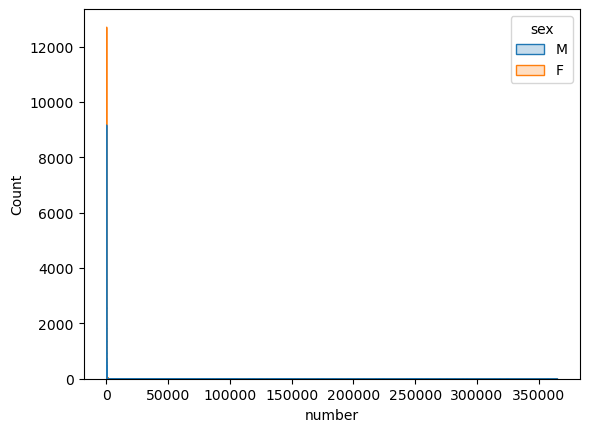

In [6]:
sns.histplot(data=namestotaldf[namestotaldf.current], x='number', hue='sex', element='step')

Here's another look, with a log scale on the x-axis. We can start seeing something of a shape now! Let's start by looking at the names that show up at least 100 times in the data. That's everything to the right of the vertical black line.

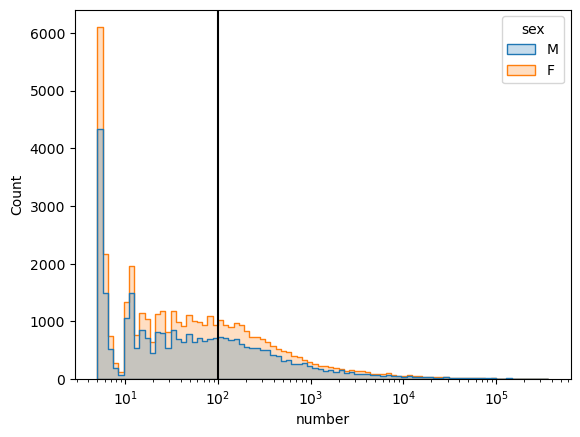

In [7]:
sns.histplot(data=namestotaldf[namestotaldf.current], x='number', hue='sex', element='step', log_scale=True)
plt.axvline(100, 0, 1, color='black')

In [8]:
namestotaldf[(namestotaldf.current) & (namestotaldf.number>100)].sort_values('number').head(20)

,name,sex,current,number
39567,Deysy,F,True,101
87010,Lamel,M,True,101
87016,Lamere,M,True,101
35109,Dashley,F,True,101
35642,Dawt,F,True,101
111545,Nole,M,True,101
20054,Braeden,F,True,101
151111,Winslet,F,True,101
139441,Tanveer,M,True,101
51350,Garv,M,True,101


That's still a bit on the unknown side for us so let's bump that up a little. That's better! We'll go with 400.

In [9]:
namestotaldf[(namestotaldf.current) & (namestotaldf.number>400)].sort_values('number').head(20)

,name,sex,current,number
36069,Deakon,M,True,401
30031,Codie,M,True,401
96434,Makensie,F,True,401
121634,Rhythm,F,True,401
1066,Abigal,F,True,401
65994,Jaydee,F,True,401
23200,Caira,F,True,401
116040,Phinehas,M,True,401
101373,Mazi,M,True,401
69253,Jhase,M,True,401


For "too popular", somewhat arbitrarily, not include the most popular 30 names.

In [10]:
toplimit = int(namestotaldf[(namestotaldf.current)].sort_values('number', ascending=False)[30:31].number)
bottomlimit = 400

In [11]:
namesdf = namestotaldf[(namestotaldf.current) & (namestotaldf.number>bottomlimit) & (namestotaldf.number<toplimit)]
namesdf

,name,sex,current,number
16,Aaden,M,True,4993
28,Aadhya,F,True,2408
33,Aadi,M,True,988
41,Aadit,M,True,442
46,Aaditya,M,True,577
...,...,...,...,...
157303,Zyon,F,True,626
157305,Zyon,M,True,2920
157313,Zyonna,F,True,520
157324,Zyra,F,True,743


## 2. Check for links with nature

Now let's see which (if any) of these names are related to trees and/or nature.

In [12]:
# Download the latest NTLK data
# Next cell might ask for an update
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/susanlin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Lookup words with `wordnet.synsets()`.
This produces a list of senses that can be accessed with `sense.definition()`.
It's important to look at the senses available and select the specific one(s) we mean, because words can have many different senses.
Here's a small example with the word "plant".

In [13]:
wordnet.synsets('plant')

[Synset('plant.n.01'),
 Synset('plant.n.02'),
 Synset('plant.n.03'),
 Synset('plant.n.04'),
 Synset('plant.v.01'),
 Synset('implant.v.01'),
 Synset('establish.v.02'),
 Synset('plant.v.04'),
 Synset('plant.v.05'),
 Synset('plant.v.06')]

wordnet.synset() returns a list of senses for the given word, but to get more information about each sense, we can use the `definition` method for senses.

In [14]:
[s.definition() for s in wordnet.synsets('plant')]

['buildings for carrying on industrial labor',
 '(botany) a living organism lacking the power of locomotion',
 'an actor situated in the audience whose acting is rehearsed but seems spontaneous to the audience',
 'something planted secretly for discovery by another',
 'put or set (seeds, seedlings, or plants) into the ground',
 'fix or set securely or deeply',
 'set up or lay the groundwork for',
 'place into a river',
 'place something or someone in a certain position in order to secretly observe or deceive',
 'put firmly in the mind']

Make a function to give relatedness between a name and a sense. For this to work well, the names will of course need to be real (if infrequent) English words.

In [15]:
# variables: a NAME (str) and a SENSE (a WordNet sense)
# returns: the strength of the shortest similarity path between the NAME and SENSE; returns 0 if no path is found
def relatedness(name, sense):
    similarity = 0
    for s in wordnet.synsets(name): # for each sense of the NAME
        tmp = s.path_similarity(sense)
        if tmp==None:
            break
        if tmp > similarity:
            similarity = tmp
    return similarity

### Short example 1

Here's a short example, comparing a set of names of varying relatedness to 'water' (meaning a body of water). First we'll figure out what the sense we want to invoke is.

In [16]:
watertestsense = wordnet.synsets('water')[1]
print(watertestsense.definition())

the part of the earth's surface covered with water (such as a river or lake or ocean)


Next put together a list of potential names, some of which have obvious relationships with the sense, some of which (we expect) don't.

In [17]:
names = ['River', 'Ocean', 'Robin', 'Clay', 'Megan', 'Brook']

for n in names:
    print("water and "+n+" relatedness: "+str(relatedness(n, watertestsense)))

water and River relatedness: 0.3333333333333333
water and Ocean relatedness: 0.5
water and Robin relatedness: 0.06666666666666667
water and Clay relatedness: 0.125
water and Megan relatedness: 0
water and Brook relatedness: 0.3333333333333333


Some of these are surprising! Let's look at some of the senses of "Robin" to try to understand where the similarity arises.

In [18]:
for s in wordnet.synsets('Robin'):
    print(s.definition())

small Old World songbird with a reddish breast
large American thrush having a rust-red breast and abdomen


### Example 2

Demonstrating that our function `relatedness` does find the maximum relatedness between the two words

In [19]:
print([s.definition() for s in wordnet.synsets('bird')])
bird = wordnet.synsets('bird')[0]

['warm-blooded egg-laying vertebrates characterized by feathers and forelimbs modified as wings', 'the flesh of a bird or fowl (wild or domestic) used as food', 'informal terms for a (young) woman', 'a cry or noise made to express displeasure or contempt', 'badminton equipment consisting of a ball of cork or rubber with a crown of feathers', 'watch and study birds in their natural habitat']


In [20]:
for s in wordnet.synsets('swallow'):
    similarity = s.path_similarity(bird)
    print('\t'.join([str(similarity),s.definition()]))
    
print("Maximum swallow and bird relatedness: "+str(relatedness("Swallow", bird)))

0.0625	a small amount of liquid food
0.07142857142857142	the act of swallowing
0.25	small long-winged songbird noted for swift graceful flight and the regularity of its migrations
0.07692307692307693	pass through the esophagus as part of eating or drinking
0.07142857142857142	engulf and destroy
0.06666666666666667	enclose or envelop completely, as if by swallowing
0.0625	utter indistinctly
0.0625	take back what one has said
0.07142857142857142	keep from expressing
0.058823529411764705	tolerate or accommodate oneself to
0.0625	believe or accept without questioning or challenge
Maximum swallow and bird relatedness: 0.25


In [21]:
print([s.definition() for s in wordnet.synsets('nature')])
nature = wordnet.synsets('nature')[2]

['the essential qualities or characteristics by which something is recognized', 'a causal agent creating and controlling things in the universe', 'the natural physical world including plants and animals and landscapes etc.', "the complex of emotional and intellectual attributes that determine a person's characteristic actions and reactions", 'a particular type of thing']


### Onto the task...

Add naturesense to names dataframe

In [22]:
namesdf['naturesense'] = namesdf.name.apply(lambda x: relatedness(x, nature))
namesdf.head()

/var/folders/mm/6ktdv6513cqg7_jcc9vz26j00000gn/T/ipykernel_61759/1235787097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  namesdf['naturesense'] = namesdf.name.apply(lambda x: relatedness(x, nature))


,name,sex,current,number,naturesense
16,Aaden,M,True,4993,0.0
28,Aadhya,F,True,2408,0.0
33,Aadi,M,True,988,0.0
41,Aadit,M,True,442,0.0
46,Aaditya,M,True,577,0.0


In [23]:
namesdf[namesdf.naturesense > 0].sort_values('naturesense', ascending=False)

,name,sex,current,number,naturesense
122675,Rock,M,True,431,0.250000
136109,Stone,M,True,3489,0.250000
29542,Clay,M,True,6411,0.200000
115726,Perseus,M,True,801,0.200000
41793,Draco,M,True,873,0.200000
...,...,...,...,...,...
53906,Gryphon,M,True,482,0.058824
99198,Marlin,M,True,1530,0.055556
99196,Marlin,F,True,451,0.055556
142660,Tia,F,True,5611,0.050000


In [24]:
def isUnisex (name, namesdf):
    return (len(namesdf[namesdf.name==name]) > 1)

In [25]:
namesdf['unisex'] = namesdf.name.apply(lambda x: isUnisex(x, namesdf))

/var/folders/mm/6ktdv6513cqg7_jcc9vz26j00000gn/T/ipykernel_61759/1966693829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  namesdf['unisex'] = namesdf.name.apply(lambda x: isUnisex(x, namesdf))


In [26]:
candidates = namesdf[namesdf.unisex & (namesdf.naturesense > 0)].sort_values('number', ascending=False).name.unique()

In [28]:
# candidates
candidates

array(['Jackson', 'Gabriel', 'Dylan', 'Christian', 'Tyler', 'Owen',
       'Carter', 'Wyatt', 'Angel', 'Hunter', 'Julian', 'Jordan', 'Aaron',
       'Austin', 'Adrian', 'Levi', 'Harper', 'Riley', 'Taylor',
       'Brooklyn', 'Chase', 'Carson', 'Cooper', 'Parker', 'Blake',
       'Sydney', 'Hudson', 'Tristan', 'Mackenzie', 'Morgan', 'Lincoln',
       'Kennedy', 'Genesis', 'Micah', 'Ashton', 'Trinity', 'Ezra', 'Max',
       'Maxwell', 'Bailey', 'Wesley', 'Jade', 'Brady', 'Jonah', 'Reagan',
       'Sawyer', 'Cody', 'Camden', 'Maverick', 'Tanner', 'Kendall',
       'Jude', 'Bennett', 'Bradley', 'London', 'Eden', 'Spencer', 'Zion',
       'Israel', 'Rowan', 'Erin', 'Emery', 'Beau', 'Nova', 'Dawson',
       'Dakota', 'Jasper', 'Brooks', 'Chance', 'Emerson', 'Marley',
       'August', 'Judah', 'Presley', 'River', 'Drew', 'Lane', 'Paxton',
       'Paris', 'Kelly', 'Dallas', 'Cadence', 'Beckett', 'Devon', 'Reid',
       'Walker', 'Messiah', 'Anderson', 'Aden', 'Phoenix', 'Ali', 'Sage',
       '